<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Model_reactor_1D_steady_state_isothermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reactions

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \end{array}


# LOAD LIBRARIES

In [1]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch as to
from scipy.integrate import odeint

# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.14.0
numpy:1.23.5
pandas:1.5.3


# SETUP

**Indexing in arrays:**

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [3]:
# @title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

L_R = 0.720               # reactor length [m]
d_R = 0.133               # reactor diameter [m]
r_R = d_R/2               # reactor radius [m]
A_R = np.pi*np.power(r_R, 2, dtype=float)                 # reactor crossectional area [a.u.]
V_R = A_R*L_R             # reactor volume [m^3]
m_cat = 250 / 1000       # catalyst mass [kg]
dens_cat_part = 3.28426/np.power(10, 3, dtype=float)      # catalyst particle density [kg m^-3]
dens_cat = m_cat/V_R      # catalyst density [kg m^-3]
p_in = 1                  # inlet pressure [bar]
n_Flow_total = 8.36812    # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5           # inlet molefraction methanol
x_H2O_in = 0.5            # inlet molefraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]
m_cat_0 = 0               # starting mass of catalyst [kg] !! typically 0
steps = 100               # number of steps in numerical calculation
dm_cat_model = (m_cat-m_cat_0)/steps                            # finite differential for numerical integration
m_cat_model_span = np.arange(m_cat_0, m_cat + dm_cat_model, dm_cat_model)   # range of mass segments for integration and plotting
R = 8.314                 # universal gas constant [J mol-1 K-1]

# placeholder values
dynvis_gas = np.power(13.3, -3, dtype=float)            # average dynamic viscosity of gas components [Pa s^-1]
D_cat = 5*np.power(10, -3, dtype=float)                    # catalyst particle diameter [m]
eps = 0.4                 # void fraction in packed bed; assumption = spherical & nearly ideally packed
vel_gas = 0.3/A_R         # gas velocity [m s^-1]
rho_gas = 0.669           # gas density [kg m^-3]

# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
# print(dens_cat)
# print(dens_cat_part)

In [4]:
# @title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

# P0_H2 = 0                     # [bar]
# P0_H2O = p_in*x_MeOH_in       # [bar]
# P0_CO = 0                     # [bar]
# P0_CO2 = 0                    # [bar]
# P0_MeOH = p_in*x_H2O_in       # [bar]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])
# IP = np.array([P0_H2, P0_H2O, P0_CO, P0_CO2, P0_MeOH, m_cat_0])

In [5]:
# @title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 8.5*np.power(10, -7, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S = 54186              # activation energy [J mol-1]
b_MeOH_MSR_S = 0.570           # rate of reaction exponent for methanol
b_H2O_MSR_S = 0.049           # rate of reaction exponent for water

#reverse MSR reaction

k0_MSR_S_rev = 4.2*np.power(10, -6, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S_rev = 4978                   # activation energy [J mol-1]
b_MeOH_MSR_S_rev = - 0.428            # rate of reaction exponent for methanol
b_H2O_MSR_S_rev = - 0.949             # rate of reaction exponent for water

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_S_rev, EA_MSR_S_rev, b_MeOH_MSR_S_rev, b_H2O_MSR_S_rev]]
)

#MD
k0_MD_S = 1.2*np.power(10, -11, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S = 132540                  # [J mol-1]
b_MeOH_MD_S = 1.114

#reverse MD reaction

k0_MD_S_rev = 5.5*np.power(10, -8, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S_rev = 42137               # [J mol-1]
b_MeOH_MD_S_rev = 0.114

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_S_rev, EA_MD_S_rev, b_MeOH_MD_S_rev]]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


# print(MSR)
# print(MSR[1,1])
#print(ny)

# PFTR ISOTHERMAL AND STEADY STATE

ODE by mass catalyst:

$\frac{d\dot{n_x}}{dm_{cat}}$=$R_x$

In [6]:
# @title reaction functions

def ReakFun (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  n_ges_temp = np.sum(P[ :-1])

  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)


  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]


  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)

  if P_MeOH > 0 and P_H2O > 0:
    revMSR = MSR[1, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMSR *= np.power(P_MeOH, MSR[1, 2], dtype=float)*np.power(P_H2O, MSR[1, 3], dtype=float)*-1
  else:
    revMSR = 0

  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)

  if P_MeOH > 0:
    revMD = MD[1, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMD *= np.power(P_MeOH, MD[1, 2], dtype=float)*-1
  else:
      revMD = 0

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])+(revMSR*ny[0, 0] + revMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])+(revMSR*ny[0, 1] + revMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])+(revMSR*ny[0, 2] + revMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])+(revMSR*ny[0, 3] + revMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])+(revMSR*ny[0, 4] + revMD*ny[1, 4])
  dP[5] = 1

  return dP

In [7]:
# @title reaction functions without reverse reaction

def ReakFunNoReverse (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  n_ges_temp = np.sum(P[ :-1])

  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)


  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)


  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)


  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1

  return dP

In [8]:
# @title euler's method

def EulFun (y, T, p_in, m_cat_span, dm_cat):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(y)])
  ytemp[0,:] = y

  for i in range(steps):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    dy = ReakFun(temp, T, p_in)

    ytemp[i+1, :] = y + dy*dm_cat

    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  for l in range(steps+1):
    n_ges = np.sum(ytemp[l, :-1])
    for j in range(5):
      ytemp[l, j] = ytemp[l, j]/n_ges*p_in

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp

In [9]:
# @title euler's method no reverse

def EulFunNoReverse (y, T, p_in, m_cat_span, dm_cat):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(IC)])
  ytemp[0,:] = y

  for i in range(steps):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    dy = ReakFunNoReverse(y, T, p_in)

    ytemp[i+1, :] = temp + dy*dm_cat

    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  for l in range(steps+1):
    n_ges = np.sum(ytemp[l, :-1])
    for j in range(5):
      ytemp[l, j] = ytemp[l, j]/n_ges*p_in

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp

In [10]:
# @title deactivation progression

def DeacFun(t):
  '''
  uses a deactivation function to calculate the change in catalytic efficiency given a time array
  '''
  eff_0 = 1
  t_0 = t[0]
  degradation = 0.03 #[h^-1]
  catalytic_efficiency = eff_0-t*degradation*eff_0

  for i in range (len(t)):
    if catalytic_efficiency [i] < 0:
      catalytic_efficiency [i] = 0
  return catalytic_efficiency

# MAIN

In [11]:
'''
contains main function to call all other relevant functions and set temperature and reaction index
'''
# set reaction temperature and calculate respective volumetric flowrate

T = 273 + 150                                                                 # reactor temperature [K]
VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))              # volumetric flowrate [m^3 h^-1]

# calculates a concentration array using euler's method, with the length Vspan for plotting

pEul = EulFun(IC, T, p_in, m_cat_model_span, dm_cat_model)
pEul [:, 5] = pEul [:, 5] / dens_cat / A_R

pEulNoReverse = EulFunNoReverse(IC, T, p_in, m_cat_model_span, dm_cat_model)
pEulNoReverse [:, 5] = pEulNoReverse [:, 5] / dens_cat / A_R

In [12]:
'''
Creates a new results data set to manipulate. Turns Pressures to molar fractions
'''

pEulfrac = pEul.copy()
for l in range(steps+1):
  n_ges = np.sum(pEulfrac[l, :-1]) * R * T / VFlow / 100
  for j in range(5):
    pEulfrac[l, j] = pEulfrac[l, j] * R * T / VFlow / 100
    pEulfrac[l, j] = pEulfrac[l, j]/n_ges

# PRODUCTION CALCULATIONS || Preliminary

In [13]:
 # @title production total

n_flow_H2_max = pEul[-1,0]
production_time_0 = 0.0
production_time_max = 40.0
production_steps = 1000
production_stepsize = (production_time_max-production_time_0)/production_steps
production_time = np.linspace(production_time_0, production_time_max, num=production_steps)
deactivation = DeacFun(production_time)
production_total = np.zeros(len(production_time))
production_hourly = deactivation*production_time*n_flow_H2_max

for i in range (len(production_time)-1):
  production_total [i+1] = deactivation[i+1]*production_stepsize*n_flow_H2_max + production_total[i]

# MAIN PLOTS

Text(0, 0.5, 'molar fraction')

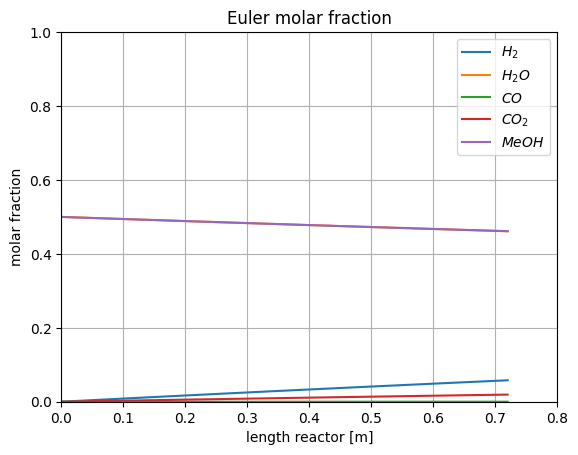

In [14]:
# @title full plot

'''
plots both reactors in the cascade using euler's method and the runge kutta method
'''

# plt.figure(1)
# plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
# plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
# plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
# plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
# plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
# plt.title("Euler pressure")
# plt.axis((0, 0.800, 0, 1))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("length reactor [m]")
# plt.ylabel ("pressure [bar]")

plt.figure(2)
plt.plot(pEulfrac[:,5], pEulfrac[:,0], label='$H_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,1], label='$H_2O$')
plt.plot(pEulfrac[:,5], pEulfrac[:,2], label='$CO$')
plt.plot(pEulfrac[:,5], pEulfrac[:,3], label='$CO_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,4], label='$MeOH$')
plt.title("Euler molar fraction")
plt.axis((0, 0.800, 0, 1))
plt.legend(loc='best')
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("molar fraction")

Text(0, 0.5, 'methanol conversion [%]')

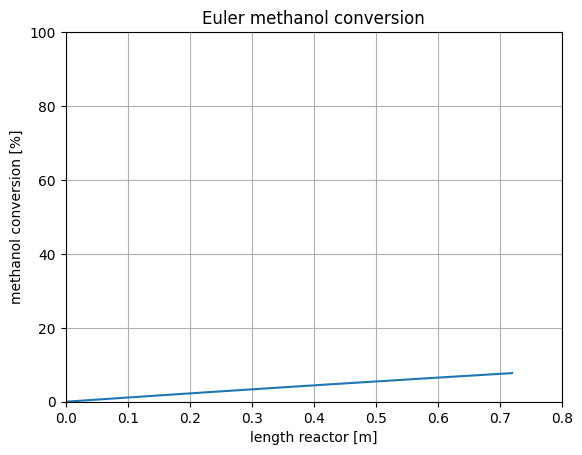

In [15]:
# @title methanol conversion

pEulfracX = pEulfrac.copy()
pEulfracX[:,4] = (1-pEulfracX[:,4]/pEulfracX[0 ,4])*100

plt.figure(1)
plt.plot(pEulfracX[:,5], pEulfracX[:,4], label='$MeOH$')
plt.title("Euler methanol conversion")
plt.axis((0, 0.8, 0, 100))
#plt.legend(loc='best')
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("methanol conversion [%]")

# pEulfracX[:,5] = pEulfracX[:,5] * dens_cat * A_R

# plt.figure(2)
# plt.plot(pEulfracX[:,5], pEulfracX[:,4], label='$MeOH$')
# plt.title("Euler methanol conversion")
# plt.axis((0, 8, 0, 100))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("mass catalyst [kg]")
# plt.ylabel ("methanol conversion [%]")

Text(0, 0.5, 'pressure [bar]')

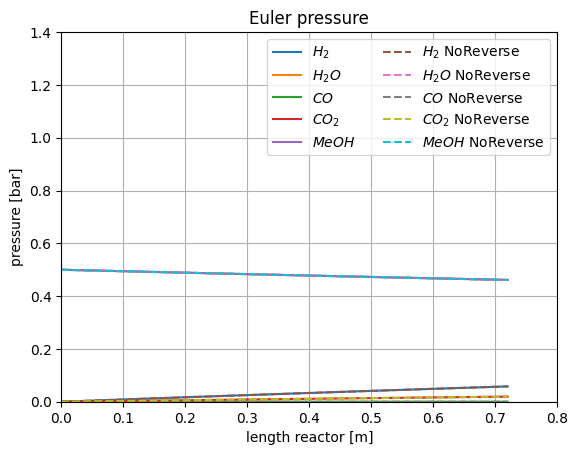

In [16]:
# @title no reverse reaction comparison

plt.figure(1)
plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,0], label='$H_2$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,1], label='$H_2O$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,2], label='$CO$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,3], label='$CO_2$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,4], label='$MeOH$ NoReverse', linestyle='--')
plt.title("Euler pressure")
plt.axis((0, 0.800, 0, 1.40))
plt.legend(loc='best', ncol=2)
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("pressure [bar]")

Text(0, 0.5, 'difference [%]')

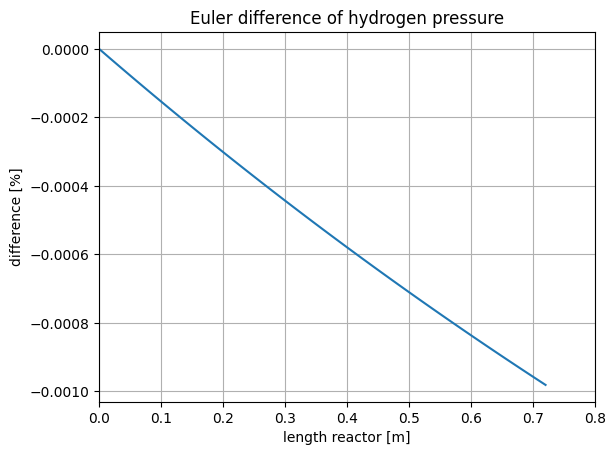

In [17]:
# @title hydrogen difference no reverse reaction

difference = (pEul[:,0]-pEulNoReverse[:,0])*100

plt.figure(1)
plt.plot(pEul[:,5], difference)
plt.title("Euler difference of hydrogen pressure")
plt.xlim(0, 0.8)
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("difference [%]")

# PRODUCTION PLOTS || Preliminary

Text(0, 0.5, 'hydrogen production [kmol]')

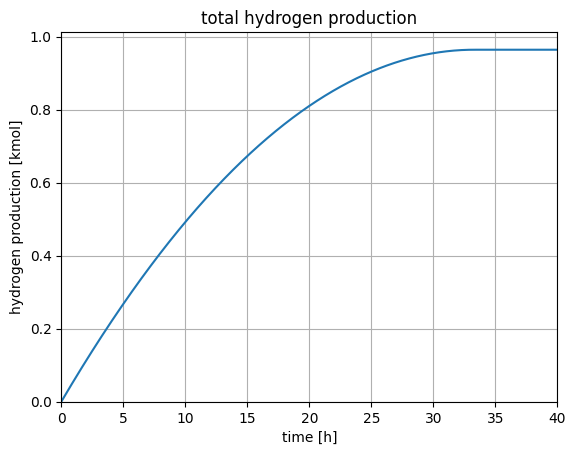

In [18]:
 # @title total hydrogen production plot

plt.figure(1)
plt.plot(production_time, production_total)
plt.title("total hydrogen production")
plt.xlim(production_time_0, production_time_max)
plt.ylim(bottom = production_time_0)
plt.grid()
plt.xlabel("time [h]")
plt.ylabel ("hydrogen production [kmol]")

Text(0, 0.5, 'hydrogen production [kmol]')

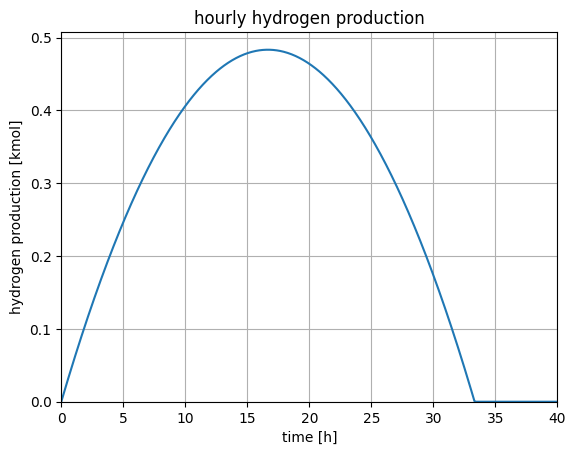

In [19]:
# @title hourly hydrogen production

plt.figure(1)
plt.plot(production_time, production_hourly)
plt.title("hourly hydrogen production")
plt.xlim(production_time_0, production_time_max)
plt.ylim(bottom = production_time_0)
plt.grid()
plt.xlabel("time [h]")
plt.ylabel ("hydrogen production [kmol]")

# MAIN ASPEN COMPARISONS

In [20]:
# @title comparative aspen arrays

'''
contains main function to call all other relevant functions, set comperative temperature/reaction data and create comperative aspen results arrays
'''

xl = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Results 720mm reactor by temp.xlsx')

AspenPoints = len(xl.sheet_names)
AspenResults = np.zeros([AspenPoints, 11, len(IC)])
sheets = xl.sheet_names

AspenStartingTemp = int(''.join(filter(str.isdigit, sheets[0])))
AspenSecondTemp = int(''.join(filter(str.isdigit, sheets[1])))
AspenEndTemp = int(''.join(filter(str.isdigit, sheets[-1])))
diff = AspenSecondTemp - AspenStartingTemp

steps_Aspen = 100

L_R_Aspen = 0.720
d_R_Aspen = 0.133
r_R_Aspen = d_R_Aspen/2
A_R_Aspen = np.pi*np.power(r_R, 2, dtype=float)
V_R_Aspen = A_R_Aspen*L_R_Aspen

m_cat_Aspen = 7.95
m_cat_0_Aspen = 0
dm_cat_Aspen = (m_cat_Aspen-m_cat_0_Aspen)/steps_Aspen
m_cat_span_Aspen = np.arange(m_cat_0_Aspen, m_cat_Aspen + dm_cat_Aspen, dm_cat_Aspen)
dens_cat_Aspen = m_cat_Aspen/V_R_Aspen

T_min = AspenStartingTemp + 273                                                    # minimum temperature boundary [K]
T_max = AspenEndTemp + 273                                                    # maximum temperature boundary [K]
T_stepsize = diff                                                            # temperature change per loop iteration [K]

temperature_arr = np.arange(0, AspenPoints)*T_stepsize + T_min               # sets temperature array to be examined
pEulTemps = np.zeros([AspenPoints, len(m_cat_span_Aspen), len(IC)])


for i in range(AspenPoints):
  df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Results 720mm reactor by temp.xlsx', i)

  df = df[['H2', 'H2O', 'CO', 'CO2', 'MEOH-1', 'Length']]
  tempres = df.to_numpy()
  res = np.delete(tempres, (0), axis=0)
  AspenResults [i, :, :] = res


for i in range (AspenPoints):
  T = temperature_arr [i]                                                 # reactor temperature [K]
  VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))        # volumetric flowrate [m^3 h^-1]
  pEulTemps [i, :, :] = EulFun(IC, T, p_in, m_cat_span_Aspen, dm_cat_Aspen)
  pEulTemps [i, :, 5] = pEulTemps [i, :, 5] / dens_cat_Aspen / A_R_Aspen

  for l in range(steps_Aspen+1):
    n_ges = np.sum(pEulTemps[i, l, :-1]) * R * T / VFlow / 100
    for j in range(5):
      pEulTemps[i, l, j] = pEulTemps[i, l, j] * R * T / VFlow / 100
      pEulTemps[i, l, j] = pEulTemps[i, l, j]/n_ges

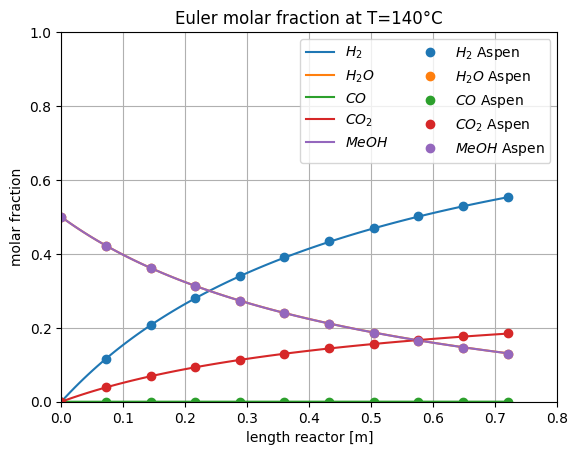

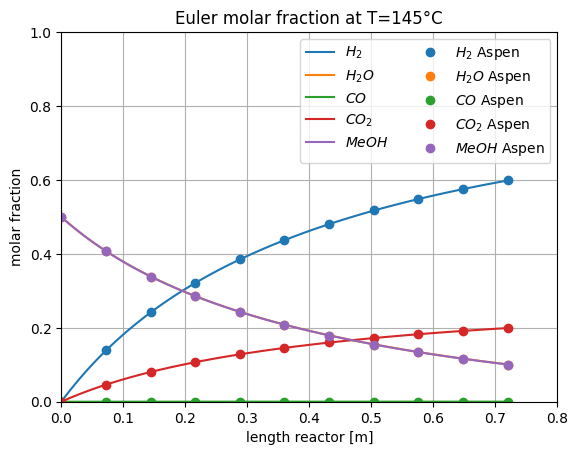

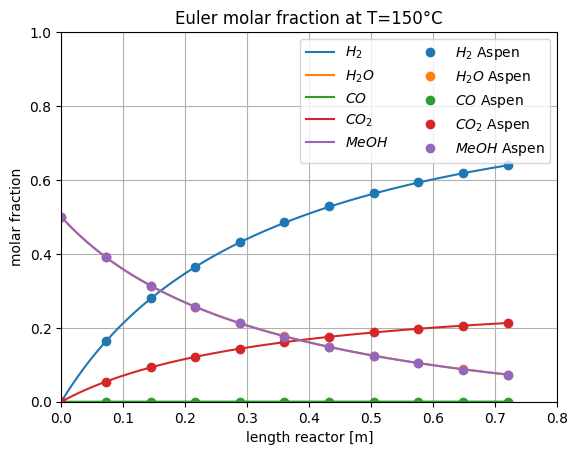

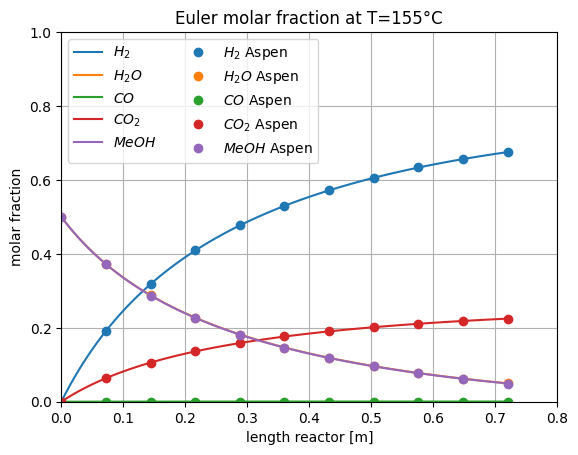

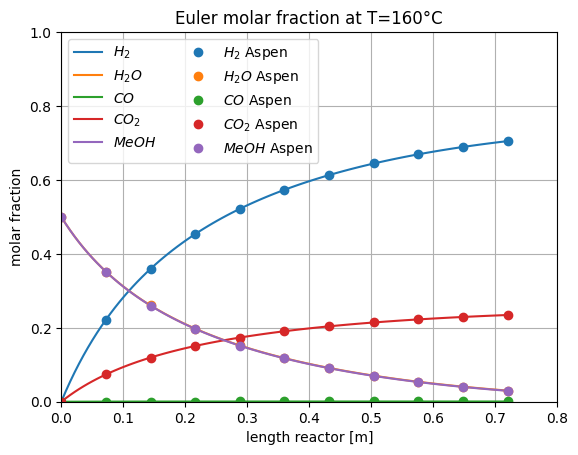

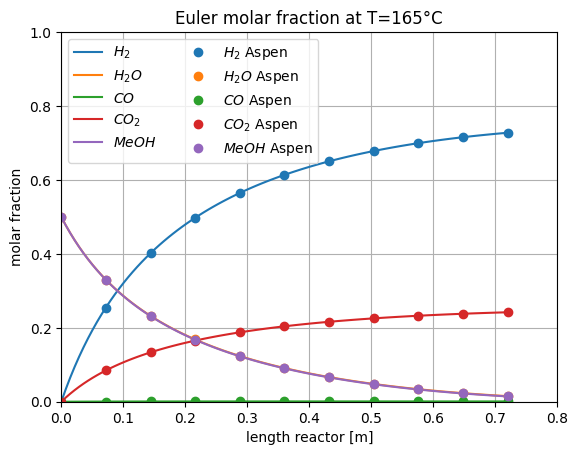

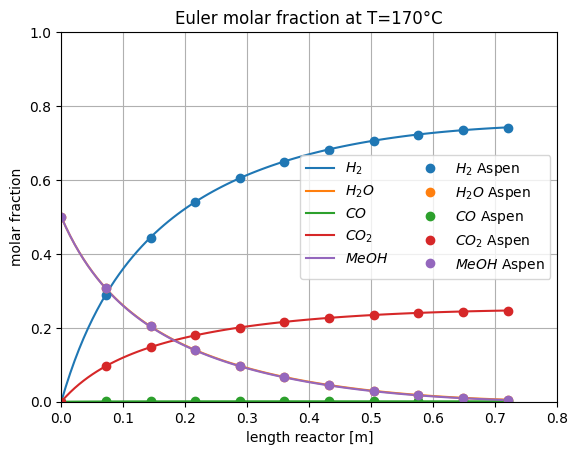

In [21]:
# @title main temp loop plots compared with aspen

for i in range (AspenPoints):
  plt.figure(i)
  t = temperature_arr[i]-273
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 0], label='$H_2$', color = 'tab:blue')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 1], label='$H_2O$', color = 'tab:orange')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 2], label='$CO$', color = 'tab:green')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 3], label='$CO_2$', color = 'tab:red')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 4], label='$MeOH$', color = 'tab:purple')
  plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 0], label='$H_2$ Aspen', marker='o', linestyle='None')
  plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 1], label='$H_2O$ Aspen', marker='o', linestyle='None')
  plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 2], label='$CO$ Aspen', marker='o', linestyle='None')
  plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 3], label='$CO_2$ Aspen', marker='o', linestyle='None')
  plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 4], label='$MeOH$ Aspen', marker='o', linestyle='None')
  # plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 0], marker='o', color = 'tab:blue')
  # plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 1], marker='o', color = 'tab:orange')
  # plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 2], marker='o', color = 'tab:green')
  # plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 3], marker='o', color = 'tab:red')
  # plt.plot(AspenResults[i, :, 5], AspenResults[i, :, 4], marker='o', color = 'tab:purple')
  plt.title('Euler molar fraction at T=%i' %t + '°C')
  plt.axis((0, 0.800, 0, 1))
  plt.legend(loc='best', ncol=2)
  plt.grid()
  plt.xlabel("length reactor [m]")
  plt.ylabel ("molar fraction")

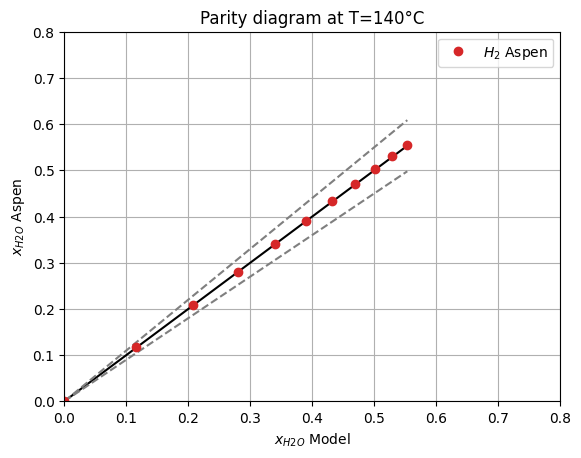

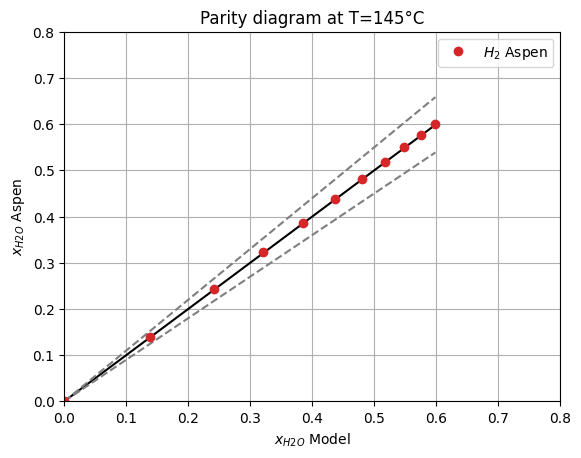

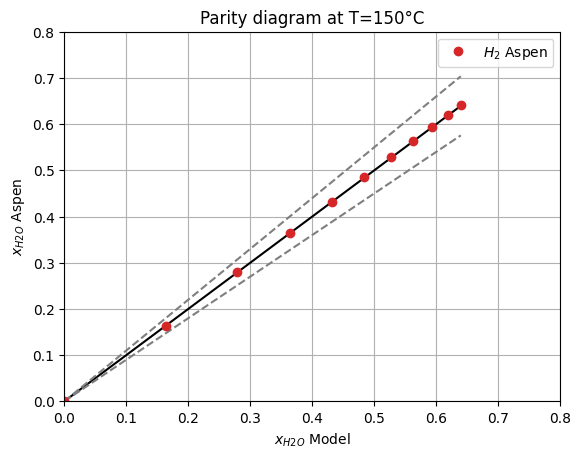

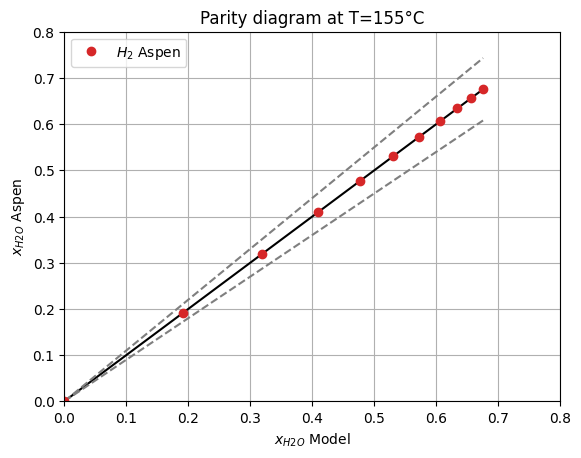

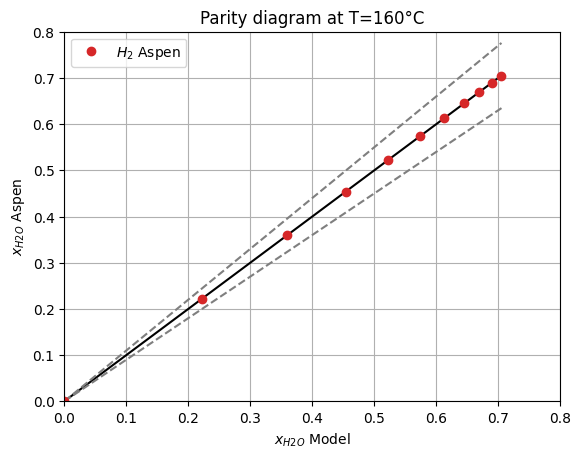

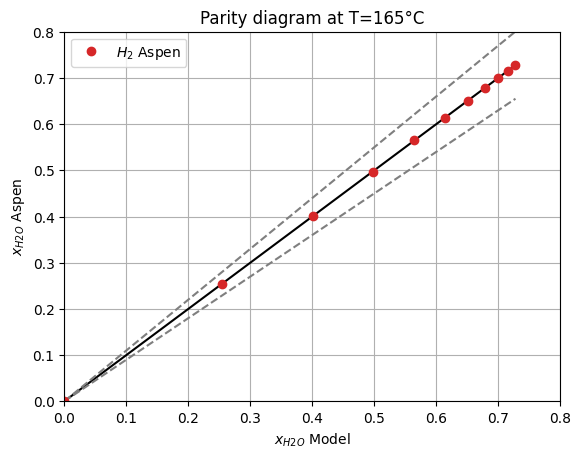

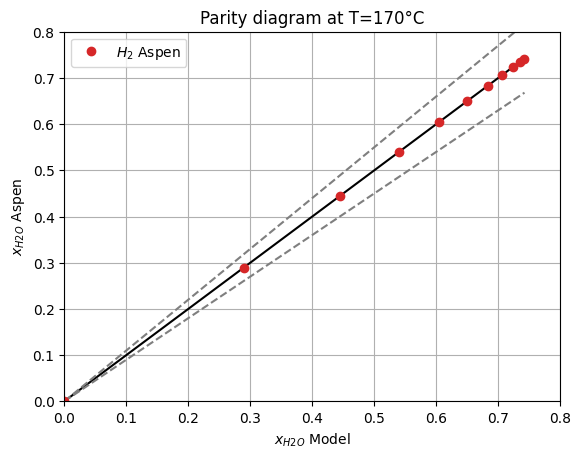

In [22]:
# @title main temp loop plots compared with aspen

ParityModelCompData = np.zeros([AspenPoints, 11])
tempind = int(steps_Aspen/10)

for i in range(AspenPoints):
  for j in range(tempind+1):
    ParityModelCompData [i, j] = pEulTemps[i, j*tempind, 0]

for i in range (AspenPoints):
  plt.figure(i)
  t = temperature_arr[i]-273
  pEulTempsMinus10 = 0.9*pEulTemps[i, :, 0]
  pEulTempsPlus10 = 1.1*pEulTemps[i, :, 0]
  plt.plot(pEulTemps[i, :, 0], pEulTemps[i, :, 0], color = 'k')
  plt.plot(pEulTemps[i, :, 0], pEulTempsMinus10, color = 'tab:gray', linestyle ='--')
  plt.plot(pEulTemps[i, :, 0], pEulTempsPlus10, color = 'tab:gray', linestyle ='--')
  plt.plot(ParityModelCompData [i , :], AspenResults[i, :, 0], label='$H_2$ Aspen', marker='o', linestyle='None', color = 'tab:red')
  plt.title('Parity diagram at T=%i' %t + '°C')
  plt.axis((0, 0.8, 0, 0.8))
  plt.legend(loc='best', ncol=2)
  plt.grid()
  plt.xlabel("$x_{H2O}$ Model")
  plt.ylabel ("$x_{H2O}$ Aspen")

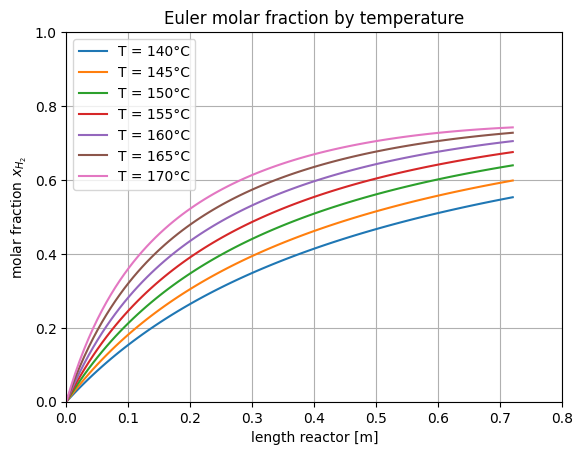

In [23]:
# @title Temp comparison molar fraction

for i in range (AspenPoints):
  plt.figure(1)
  t = temperature_arr[i]-273
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 0], label='T = %i' %t + '°C')
  plt.title('Euler molar fraction by temperature')
  plt.axis((0, 0.800, 0, 1))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("length reactor [m]")
  plt.ylabel ("molar fraction $x_{H_2}$")


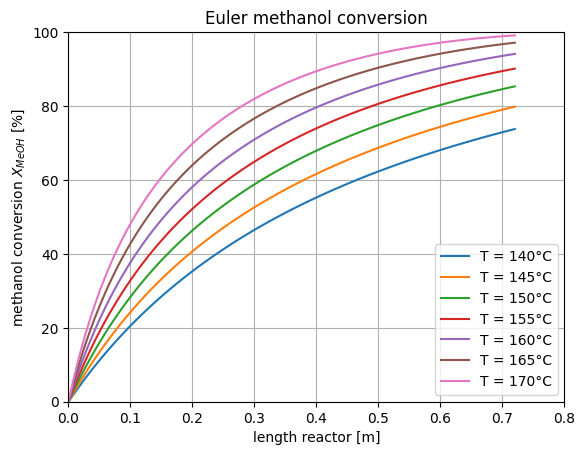

In [24]:
# @title Temp comparison methanol conversion rate

pEulTempsX = pEulTemps.copy()

for j in range (AspenPoints):
  pEulTempsX[j, :, 4] = (1-pEulTempsX[j ,: ,4]/pEulTempsX[j ,0 ,4])*100
  plt.figure(1)
  t = temperature_arr[j]-273
  plt.plot(pEulTempsX[j, :, 5], pEulTempsX[j, :, 4], label='T = %i' %t + '°C')
  plt.title("Euler methanol conversion")
  plt.axis((0, 0.8, 0, 100))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("length reactor [m]")
  plt.ylabel ("methanol conversion $X_{MeOH}$ [%]")

# complementary functions

In [25]:
# @title Ergun

def Ergun (p, L):
  '''
  ergun's equation
  '''
  p = p*np.power(10, 5, dtype=float)
  dp = 150*dynvis_gas*L/np.power(D_cat, 2, dtype=float)*np.power((1-eps), 2, dtype=float)/np.power(eps, 3, dtype=float)*vel_gas
  + (1.75*L*rho_gas)/D_cat*1-eps/np.power(eps, 3, dtype=float)*vel_gas


  p_neu = p - dp
  p_neu = p_neu/np.power(10, 5, dtype=float)
  return p_neu, dp

In [26]:
# @title Temperature ODE

def TempODE ():
  '''
  Temperature ODE
  '''

  dT = 1


  return dT

In [27]:
# @title dynamic viscosity @400K in microPascals per second

h2 = 10.9
co2 = 20.9
h2o = 13.4
ch3oh = 13

zero_conv = 0.5*h2o + 0.5*ch3oh
full_conv = 0.75*h2 + 0.25*co2
median = (zero_conv+full_conv)/2

print ("dynamic viscosity at zero conversion = " + str(zero_conv))
print ("dynamic viscosity at full conversion = "+ str(full_conv))
print ("median dynamic viscosity = " + str(median))

for i in range (3):
  T = 400+ i*25
  VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))
  print ("volumetric flowrate = " + str(VFlow))

Mh2 = 2.016
Mco2 = 44.01
Mh2o = 18.016
Mch3oh = 32.02

# 1 bar at zero conv, 2 bar at full conversion
M_zero_conv = (0.5*Mh2o + 0.5*Mch3oh)/1000
M_full_conv = (0.75*Mh2 + 0.25*Mco2)/1000

dens_zero_conv = M_zero_conv/R/T*np.power(10, 5, dtype = float)
dens_full_conv = M_full_conv/R/T*2*np.power(10, 5, dtype = float)

print ("gas density at zero conversion = " + str(dens_zero_conv))
print ("gas density at full conversion = " + str(dens_full_conv))

# dens_h2 =
# dens_h2o =
# dens_co2 =
# dens_ch3oh =

dynamic viscosity at zero conversion = 13.2
dynamic viscosity at full conversion = 13.4
median dynamic viscosity = 13.3
volumetric flowrate = 0.27829019872
volumetric flowrate = 0.29568333614
volumetric flowrate = 0.31307647355999996
gas density at zero conversion = 0.6686980461336968
gas density at full conversion = 0.6689920615828722


In [28]:
Ergun(2, L_R)

(-0.2303829788536139, 223038.2978853614)